<a href="https://colab.research.google.com/github/wendycataldo/A_dissertacao/blob/main/Avalia%C3%A7%C3%A3o_do_questionario_professores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cabeçalho

In [41]:
import pandas as pd
import re

from google.colab import drive

In [42]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
caminho_questionario = '/content/drive/MyDrive/Analises dados dis/Experimento (respostas).xlsx'

df_questionario = pd.read_excel(caminho_questionario)

In [44]:
novos_nomes = {
    '1 - Qual sua idade?': 'Idade',
    '2 - Você possui pós-graduação?': 'Pos_Graduacao',
    '3- Instituição de ensino que leciona atualmente (ou a principal, caso lecione em mais de uma)?': 'Instituicao',
    '4 - Há quanto tempo você atua como professor(a) (considerando todas as disciplinas e níveis)?': 'Tempo_Experiencia',
    '5 - Com que frequência você elabora suas próprias questões para as avaliações que aplica?': 'Frequencia_Elaboracao',
    '6 - Em média, quanto tempo você dedica à criação de exercícios e avaliações para uma turma por semana?': 'Tempo_Dedicado',
    '7 - Como você avalia seu nível de estresse como professor?': 'Nivel_Estresse',
    '8 - Como você avalia sua satisfação profissional como professor?': 'Satisfacao_Profissional',
    '9 - Você já utilizou alguma ferramenta específica para criar questões anteriormente?': 'Ferramentas_Anteriores',
    '10 - Especificamente sobre LLMs como ChatGPT, Gemini, etc., você já teve experiência prévia em usá-los para alguma finalidade (profissional ou pessoal)?': 'Experiencia_LLMs',
    '11 - Você acredita que o uso do LLM pode ser uma ferramenta útil para professores na criação de exercícios?': 'Utilidade_LLMs'
}

df_questionario = df_questionario.rename(columns=novos_nomes)

In [45]:
colunas_perfil = [
    'Carimbo de data/hora',
    'Declaro ter lido e aceito o TCLE acima exposto.',
    'Idade',
    'Pos_Graduacao',
    'Instituicao',
    'Tempo_Experiencia',
    'Frequencia_Elaboracao',
    'Tempo_Dedicado',
    'Nivel_Estresse',
    'Satisfacao_Profissional',
    'Ferramentas_Anteriores',
    'Experiencia_LLMs',
    'Utilidade_LLMs'
]

In [46]:
criterios_validos = [
    "Cobertura",
    "Gramaticalidade",
    "Utilidade",
    "Relevância",
    "Capacidade de resposta"
]

# Constrói padrão de critérios
padrao_criterios = "|".join([re.escape(c) for c in criterios_validos])

# Regex robusta, aceita múltiplos espaços, e separa sempre: questao + criterio + llm + opcional Meta/prompt
padrao_regex = re.compile(
    rf'^\s*(\d+)\s+({padrao_criterios})\s+(DeepSeek|Mistal|ChatGPT|Professor)(?:\s+(Meta|prompt))?\s*$',
    re.IGNORECASE
)
def separa_coluna(col_nome):
    col_nome = re.sub(r'\s+', ' ', col_nome.strip()) # Normaliza espaços
    m = padrao_regex.match(col_nome)
    if m:
        n_quest = int(m.group(1))
        criterio = m.group(2).strip()
        llm = m.group(3).strip()
        tipo_prompt = m.group(4) if m.group(4) else ("Professor" if llm.lower() == "professor" else "prompt")
        return n_quest, criterio, llm, tipo_prompt
    else:
        return None, None, None, None

# Confirme no DataFrame:
colunas_criterios = [col for col in df_questionario.columns if col not in colunas_perfil]

# TRANSFORMAÇÃO PARA FORMATO LONG
avaliacoes_long = []
for idx, row in df_questionario.iterrows():
    perfil = row[colunas_perfil].to_dict()
    for col in colunas_criterios:
        valor = row[col]
        n_q, criterio, llm, tipo_prompt = separa_coluna(col)
        if criterio:
            avaliacoes_long.append({
                **perfil,
                'Questao': n_q,
                'Criterio': criterio,
                'LLM': llm,
                'Tipo_Prompt': tipo_prompt,
                'Valor': valor
            })

df_long = pd.DataFrame(avaliacoes_long)

In [47]:
print(df_long['Criterio'].unique())
print(df_long['LLM'].unique())
print(df_long['Tipo_Prompt'].unique())

['Cobertura' 'Gramaticalidade' 'Utilidade' 'Relevância'
 'Capacidade de resposta']
['Professor' 'DeepSeek' 'Mistal' 'ChatGPT']
['Professor' 'prompt' 'Meta']


In [62]:
df_long.groupby(['Criterio', 'LLM', 'Tipo_Prompt'])['Valor'].agg(['mean', 'std', 'count'])

mean       std  count
Criterio               LLM       Tipo_Prompt                           
Capacidade de resposta ChatGPT   Meta         4.251029  1.043847    243
                                 prompt       4.049383  1.187760    243
                       DeepSeek  Meta         4.259259  0.941835    243
                                 prompt       4.230453  1.030716    243
                       Mistal    Meta         4.316872  0.950426    243
                                 prompt       4.189300  1.066570    243
                       Professor Professor    4.401235  0.999751    162
Cobertura              ChatGPT   Meta         4.160494  0.972219    243
                                 prompt       4.049383  0.998775    243
                       DeepSeek  Meta         4.213992  0.980960    243
                                 prompt       4.123457  1.008838    243
                       Mistal    Meta         4.102881  1.099263    243
                                 prompt       3.921811  1.116211    243
                       Professor Professor    4.246914  0.984739    162
Gramaticalidade        ChatGPT   Meta         4.345679  0.997855    243
                                 prompt       4.267490  1.047652    243
                       DeepSeek  Meta         4.337449  1.045117    243
                                 prompt       4.337449  0.984024    243
                       Mistal    Meta         4.415638  0.951338    243
                                 prompt       4.329218  1.027841    243
                       Professor Professor    4.388889  1.010811    162
Relevância             ChatGPT   Meta         4.218107  1.011178    243
                                 prompt       4.061728  1.087255    243
                       DeepSeek  Meta         4.069959  1.101859    243
                                 prompt       4.074074  1.061472    243
                       Mistal    Meta         4.106996  1.006627    243
                                 prompt       4.102881  1.064894    243
                       Professor Professor    4.277778  0.998446    162
Utilidade              ChatGPT   Meta         4.057613  1.022865    243
                                 prompt       3.979424  0.989401    243
                       DeepSeek  Meta         4.189300  0.943206    243
                                 prompt       4.053498  1.025107    243
                       Mistal    Meta         4.053498  1.017013    243
                                 prompt       3.958848  1.163474    243
                       Professor Professor    4.179012  0.925178    162

# Analises

1. Estatísticas descritivas por Critério, LLM e Tipo de Prompt

In [63]:
# Estatísticas resumidas (média, desvio, contagem)
estatisticas = (
    df_long
    .groupby(['Criterio', 'LLM', 'Tipo_Prompt'])['Valor']
    .agg(['mean', 'std', 'count'])
    .reset_index()
    .rename(columns={'mean': 'Media', 'std': 'Desvio_Padrao', 'count': 'N'})
)
print(estatisticas)


                  Criterio        LLM Tipo_Prompt     Media  Desvio_Padrao  \
0   Capacidade de resposta    ChatGPT        Meta  4.251029       1.043847   
1   Capacidade de resposta    ChatGPT      prompt  4.049383       1.187760   
2   Capacidade de resposta   DeepSeek        Meta  4.259259       0.941835   
3   Capacidade de resposta   DeepSeek      prompt  4.230453       1.030716   
4   Capacidade de resposta     Mistal        Meta  4.316872       0.950426   
5   Capacidade de resposta     Mistal      prompt  4.189300       1.066570   
6   Capacidade de resposta  Professor   Professor  4.401235       0.999751   
7                Cobertura    ChatGPT        Meta  4.160494       0.972219   
8                Cobertura    ChatGPT      prompt  4.049383       0.998775   
9                Cobertura   DeepSeek        Meta  4.213992       0.980960   
10               Cobertura   DeepSeek      prompt  4.123457       1.008838   
11               Cobertura     Mistal        Meta  4.102881     

2. Gráfico de comparação (exemplo: Cobertura)

/tmp/ipython-input-64-66097624.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


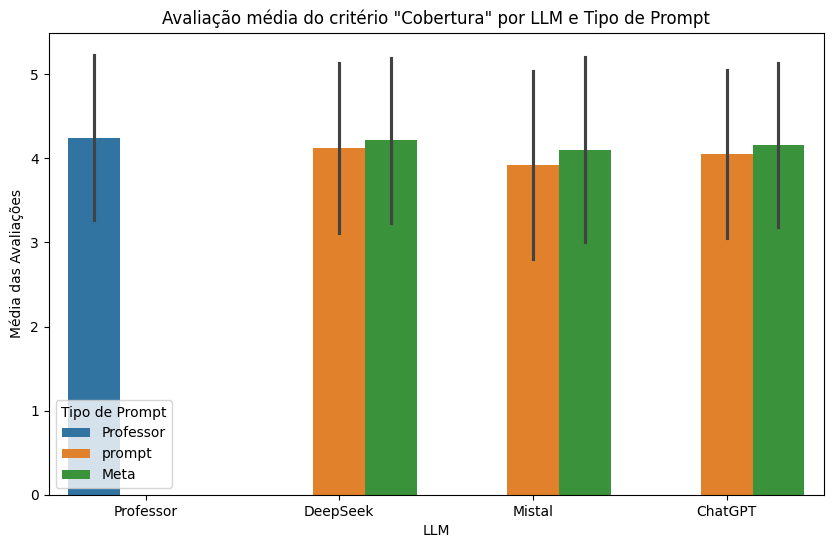

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

criterio_exemplo = 'Cobertura'  # Pode trocar por outro critério

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_long[df_long['Criterio']==criterio_exemplo],
    x='LLM',
    y='Valor',
    hue='Tipo_Prompt',
    ci='sd'
)
plt.title(f'Avaliação média do critério "{criterio_exemplo}" por LLM e Tipo de Prompt')
plt.ylabel('Média das Avaliações')
plt.xlabel('LLM')
plt.legend(title='Tipo de Prompt')
plt.show()


3. Estatísticas por questão (opcional, detalhamento por questão)

In [65]:
estatisticas_questao = (
    df_long
    .groupby(['Questao', 'Criterio', 'LLM', 'Tipo_Prompt'])['Valor']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)
print(estatisticas_questao.head())


   Questao                Criterio        LLM Tipo_Prompt      mean       std  \
0        1  Capacidade de resposta  Professor   Professor  4.382716  1.067332   
1        1               Cobertura  Professor   Professor  4.234568  1.087102   
2        1         Gramaticalidade  Professor   Professor  4.358025  1.028453   
3        1              Relevância  Professor   Professor  4.271605  1.036971   
4        1               Utilidade  Professor   Professor  4.222222  0.935414   

   count  
0     81  
1     81  
2     81  
3     81  
4     81  


# Análise por perfil docente

1. Exemplo: Médias por nível de experiência docente
(para cada LLM e tipo de prompt, sempre na mesma escala)

Primeiro, transforme a experiência em um dado numérico ordenável:

In [66]:
# Mapeamento de faixas de experiência para valores médios aproximados (ajuste conforme seu questionário!)
map_exp = {
    'Menos de 1 ano': 0.5,
    '1 a 5 anos': 3,
    '6 a 10 anos': 8,
    '11 a 15 anos': 13,
    '16 a 20 anos': 18,
    'Mais de 20 anos': 25
}
df_long['Tempo_Experiencia_Num'] = df_long['Tempo_Experiencia'].map(map_exp)

2. Gráfico: Avaliação média por Tempo de Experiência (anos), LLM e Tipo_Prompt
(vou usar “Cobertura” como exemplo; troque para outro critério se desejar)

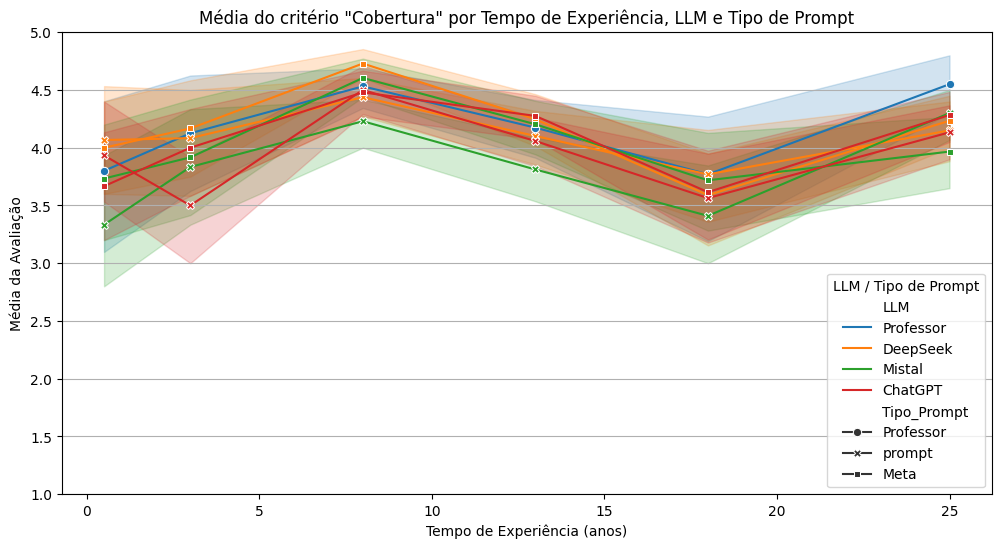

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

criterio_exemplo = 'Cobertura'

plt.figure(figsize=(12,6))

sns.lineplot(
    data=df_long[df_long['Criterio']==criterio_exemplo],
    x='Tempo_Experiencia_Num',
    y='Valor',
    hue='LLM',
    style='Tipo_Prompt',
    markers=True,
    dashes=False,
    palette='tab10'
)

plt.ylim(1,5)  # Escala padronizada da variável Valor (ajuste se seus dados forem de outra faixa)
plt.title(f'Média do critério "{criterio_exemplo}" por Tempo de Experiência, LLM e Tipo de Prompt')
plt.xlabel('Tempo de Experiência (anos)')
plt.ylabel('Média da Avaliação')
plt.legend(title='LLM / Tipo de Prompt')
plt.grid(True, axis='y')
plt.show()


3. Gráfico de barras: Comparação por categoria de experiência

/tmp/ipython-input-68-516565636.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


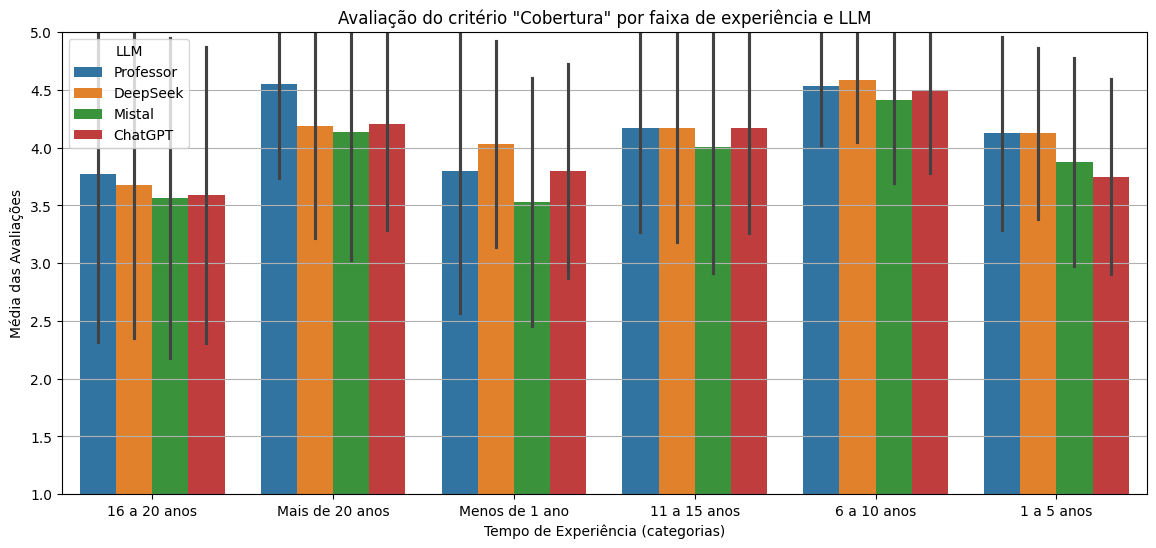

In [68]:
plt.figure(figsize=(14,6))
sns.barplot(
    data=df_long[df_long['Criterio']==criterio_exemplo],
    x='Tempo_Experiencia',
    y='Valor',
    hue='LLM',
    ci='sd',
    palette='tab10',
    dodge=True
)
plt.ylim(1,5)
plt.title(f'Avaliação do critério "{criterio_exemplo}" por faixa de experiência e LLM')
plt.ylabel('Média das Avaliações')
plt.xlabel('Tempo de Experiência (categorias)')
plt.legend(title='LLM')
plt.grid(True, axis='y')
plt.show()


4. Comparação por Titulação do Docente

/tmp/ipython-input-69-2469885839.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


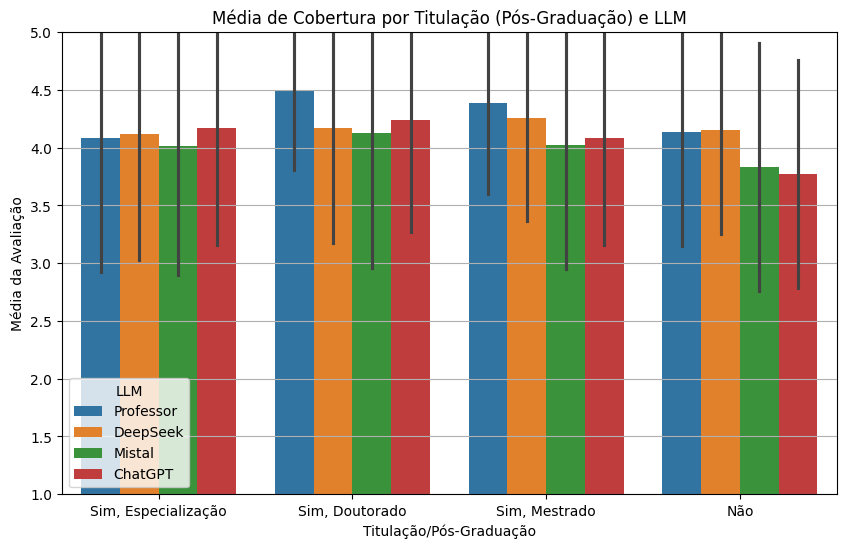

In [69]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_long[df_long['Criterio']=="Cobertura"],
    x='Pos_Graduacao',
    y='Valor',
    hue='LLM',
    ci='sd',
    palette='tab10'
)
plt.ylim(1,5)
plt.title('Média de Cobertura por Titulação (Pós-Graduação) e LLM')
plt.xlabel('Titulação/Pós-Graduação')
plt.ylabel('Média da Avaliação')
plt.legend(title='LLM')
plt.grid(True, axis='y')
plt.show()


5. Comparação por Satisfação Profissional

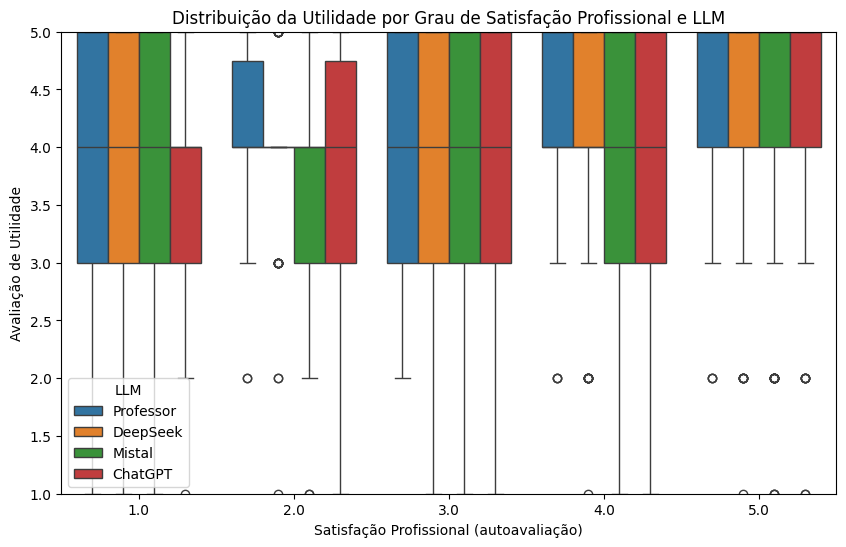

In [70]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_long[df_long['Criterio']=="Utilidade"],
    x='Satisfacao_Profissional',
    y='Valor',
    hue='LLM',
    palette='tab10'
)
plt.ylim(1,5)
plt.title('Distribuição da Utilidade por Grau de Satisfação Profissional e LLM')
plt.xlabel('Satisfação Profissional (autoavaliação)')
plt.ylabel('Avaliação de Utilidade')
plt.legend(title='LLM')
plt.show()


6. Comparação por Frequência de Elaboração de Questões

/tmp/ipython-input-71-3068335154.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


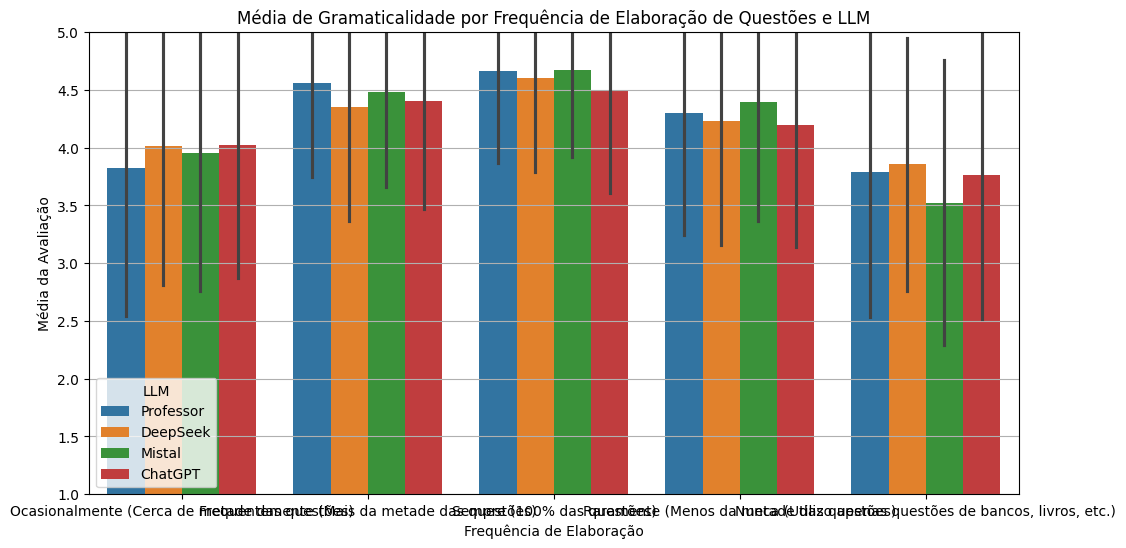

In [71]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=df_long[df_long['Criterio']=="Gramaticalidade"],
    x='Frequencia_Elaboracao',
    y='Valor',
    hue='LLM',
    ci='sd',
    palette='tab10'
)
plt.ylim(1,5)
plt.title('Média de Gramaticalidade por Frequência de Elaboração de Questões e LLM')
plt.xlabel('Frequência de Elaboração')
plt.ylabel('Média da Avaliação')
plt.legend(title='LLM')
plt.grid(True, axis='y')
plt.show()


7. Comparação por Nível de Estresse Autodeclarado

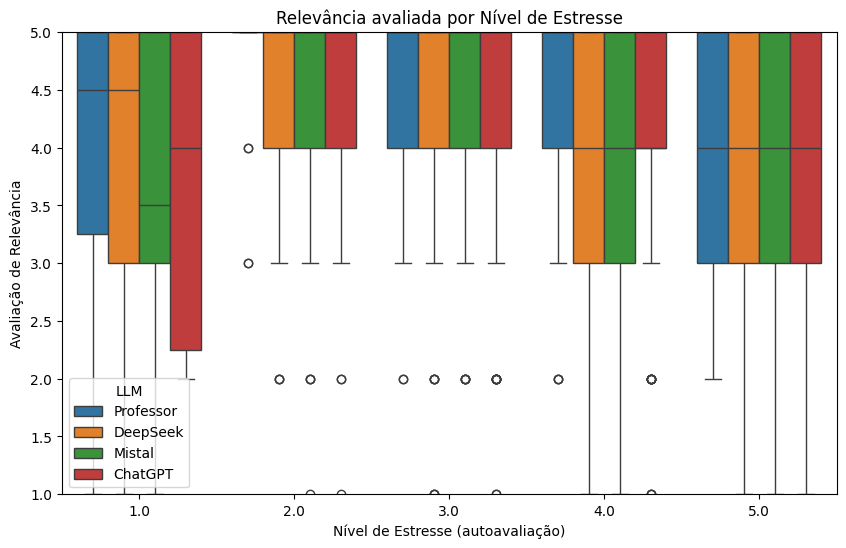

In [72]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_long[df_long['Criterio']=="Relevância"],
    x='Nivel_Estresse',
    y='Valor',
    hue='LLM',
    palette='tab10'
)
plt.ylim(1,5)
plt.title('Relevância avaliada por Nível de Estresse')
plt.xlabel('Nível de Estresse (autoavaliação)')
plt.ylabel('Avaliação de Relevância')
plt.legend(title='LLM')
plt.show()


8. Comparação por Experiência Prévia com LLMs

/tmp/ipython-input-73-3277202334.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


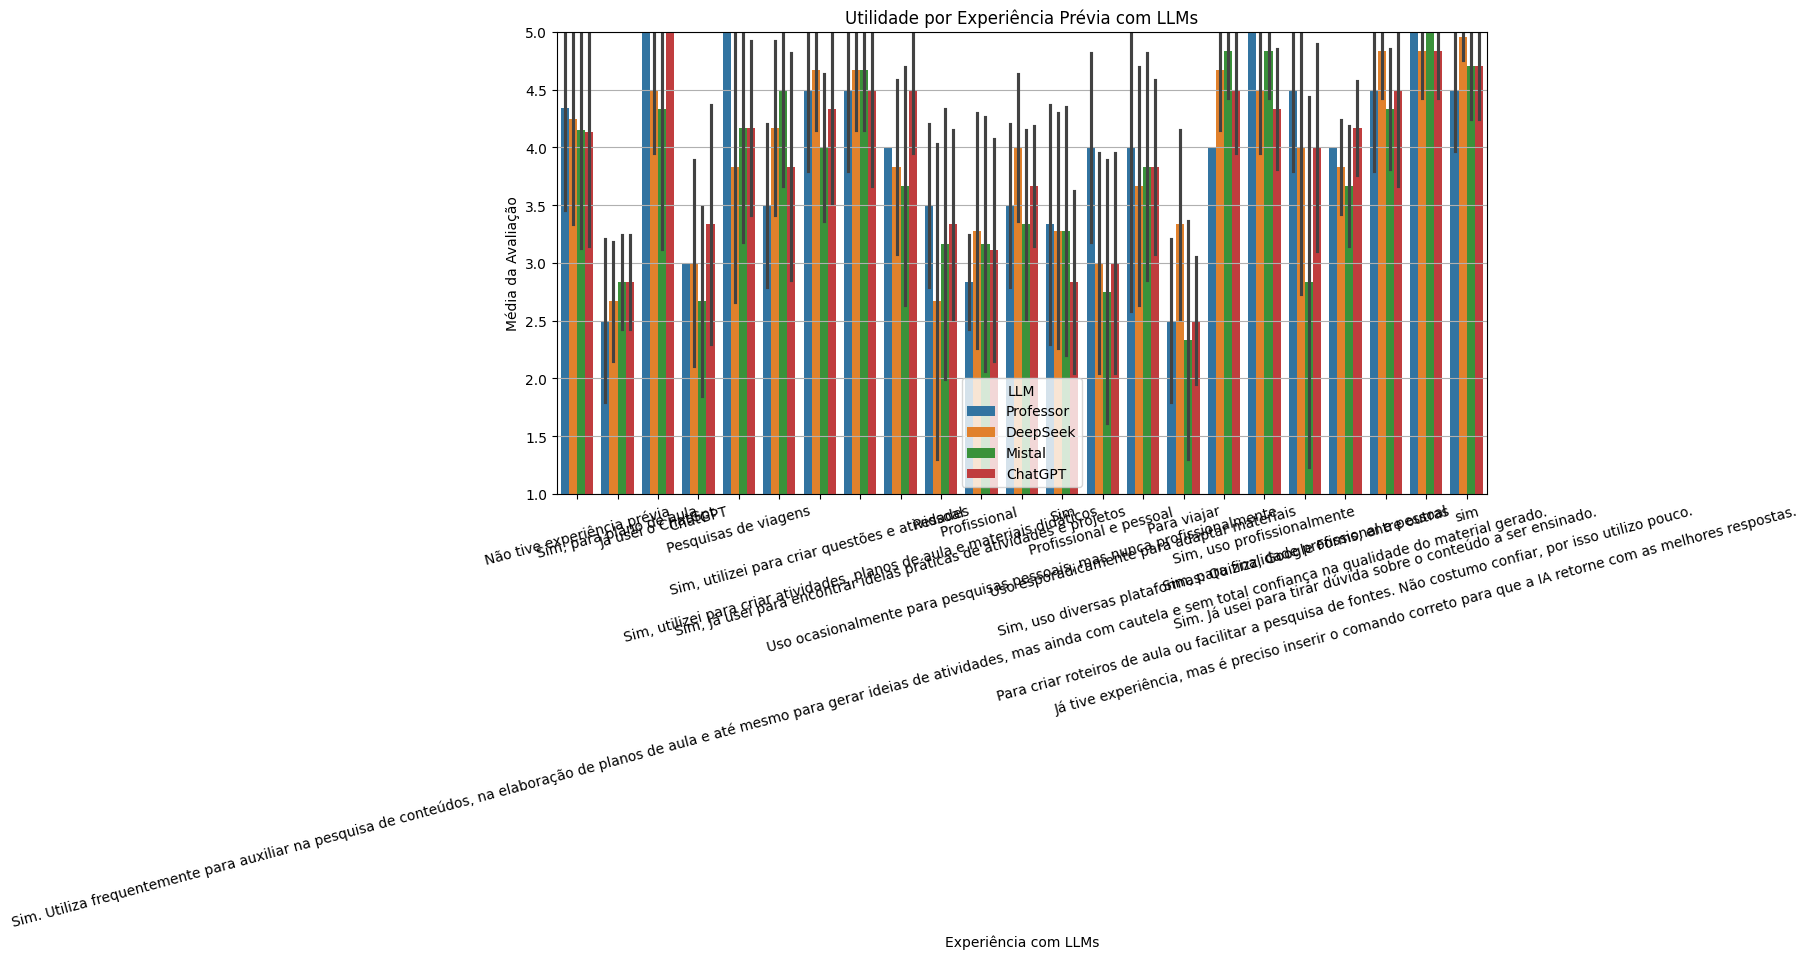

In [73]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=df_long[df_long['Criterio']=="Utilidade"],
    x='Experiencia_LLMs',
    y='Valor',
    hue='LLM',
    ci='sd',
    palette='tab10'
)
plt.ylim(1,5)
plt.xticks(rotation=15)
plt.title('Utilidade por Experiência Prévia com LLMs')
plt.xlabel('Experiência com LLMs')
plt.ylabel('Média da Avaliação')
plt.legend(title='LLM')
plt.grid(True, axis='y')
plt.show()


9. Segmentação Multivariada: Combinação de Perfil + Tipo de Questão

/tmp/ipython-input-74-1998651211.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


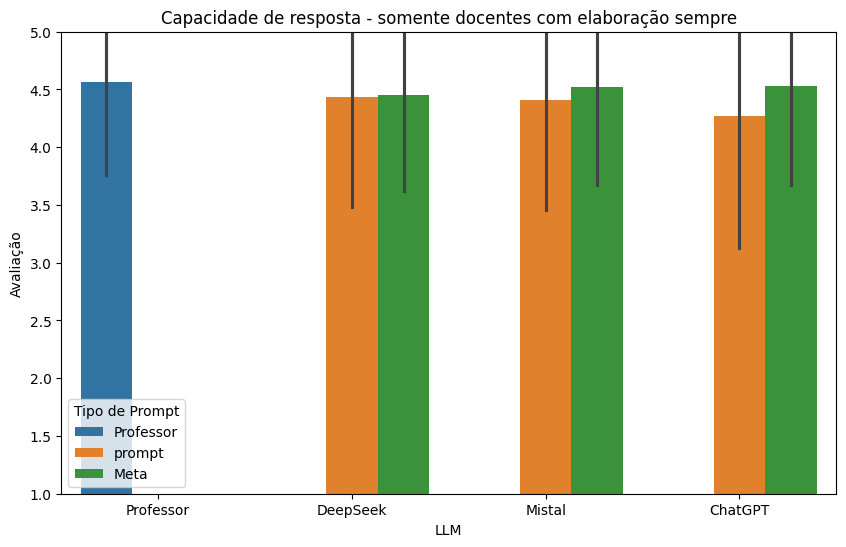

In [74]:
filtro = (
    (df_long['Frequencia_Elaboracao'] == 'Sempre (100% das questões)') &
    (df_long['Criterio'] == 'Capacidade de resposta')
)
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_long[filtro],
    x='LLM',
    y='Valor',
    hue='Tipo_Prompt',
    ci='sd',
    palette='tab10'
)
plt.ylim(1,5)
plt.title('Capacidade de resposta - somente docentes com elaboração sempre')
plt.xlabel('LLM')
plt.ylabel('Avaliação')
plt.legend(title='Tipo de Prompt')
plt.show()


In [76]:
# Exemplo: só escolas públicas e critério 'Cobertura'
pub_cob = df_long[(df_long['Instituicao'].str.contains("pública", case=False)) &
                  (df_long['Criterio']=="Cobertura")]
# Exemplo: só professores com mais de 20 anos de experiência e nível de estresse alto
estresse_alto = df_long[(df_long['Tempo_Experiencia']=="Mais de 20 anos") &
                        (df_long['Nivel_Estresse']>=4)]
# Exemplo: professores de escolas privadas, pós-graduados, que avaliam Meta do Mistal
filtro_especial = df_long[
    (df_long['Instituicao'].str.contains("privada", case=False)) &
    (df_long['Pos_Graduacao'].str.lower().str.contains("mestrado|doutorado")) &
    (df_long['LLM']=="Mistal") &
    (df_long['Tipo_Prompt']=="Meta")
]